# Fourier transform

In this part, we look at the effect of filtering in Fourier space.

This gives us a different way of looking at images and yields deeper insights to what is going on when we apply a filter or downsample an image.

In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
from scipy import ndimage
import cv2


Bad key "text.kerning_factor" on line 4 in
/home/pk/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Some convenience functions

In [2]:
def imread_gray(filename):
    """Read grayscale image from our data directory."""
    return cv2.imread(f'../data/{filename}',
                      cv2.IMREAD_GRAYSCALE).astype(np.float32)

def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1, mode='wrap')
    image = ndimage.convolve(image, kernel2, mode='wrap')
    return image

def fourier_spectrum(im):
    normalized_im = im / np.sum(im)
    f = np.fft.fft2(normalized_im)
    return np.fft.fftshift(f)

def log_magnitude_spectrum(im):
    return np.log(np.abs(fourier_spectrum(im))+1e-8)

def plot_with_spectra(images, titles):
    """Plots a list of images in the first column and the logarithm of their
    magnitude spectrum in the second column."""
    
    assert len(images) == len(titles)
    n_cols = 2
    n_rows = len(images)
    fig, axes = plt.subplots(
        n_rows, 2, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False)

    spectra = [log_magnitude_spectrum(im) for im in images]

    lower = min(np.percentile(s, 0.1) for s in spectra)
    upper = min(np.percentile(s, 99.999) for s in spectra)
    normalizer = mpl.colors.Normalize(vmin=lower, vmax=upper)
    
    for ax, image, spectrum, title in zip(axes, images, spectra, titles):
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title(title)
        ax[0].set_axis_off()
        c = ax[1].imshow(spectrum, norm=normalizer, cmap='viridis')
        ax[1].set_title('Log magnitude spectrum')
        ax[1].set_axis_off()
        
    fig.tight_layout()
    
def generate_pattern():
    x = np.linspace(0, 1, 256, endpoint=False)
    y = np.sin(x**2 * 16 * np.pi)
    #If the two vectors have dimensions n and m, then their outer product is an n × m matrix.
    return np.outer(y,y)/2+0.5

im_grass = imread_gray('grass.jpg')
im_zebras = imread_gray('zebras.jpg')
im_pattern = generate_pattern()

## Plotting demo
This is how you can load example images and plot the logarithm of its magnitude spectrum.

Low frequencies appear near the center and higher frequencies towards the outside.

Greener (lighter) colors mean higher values. The color scale is consistent within the subplots of a single plot, but may differ in different plots.

<IPython.core.display.Javascript object>


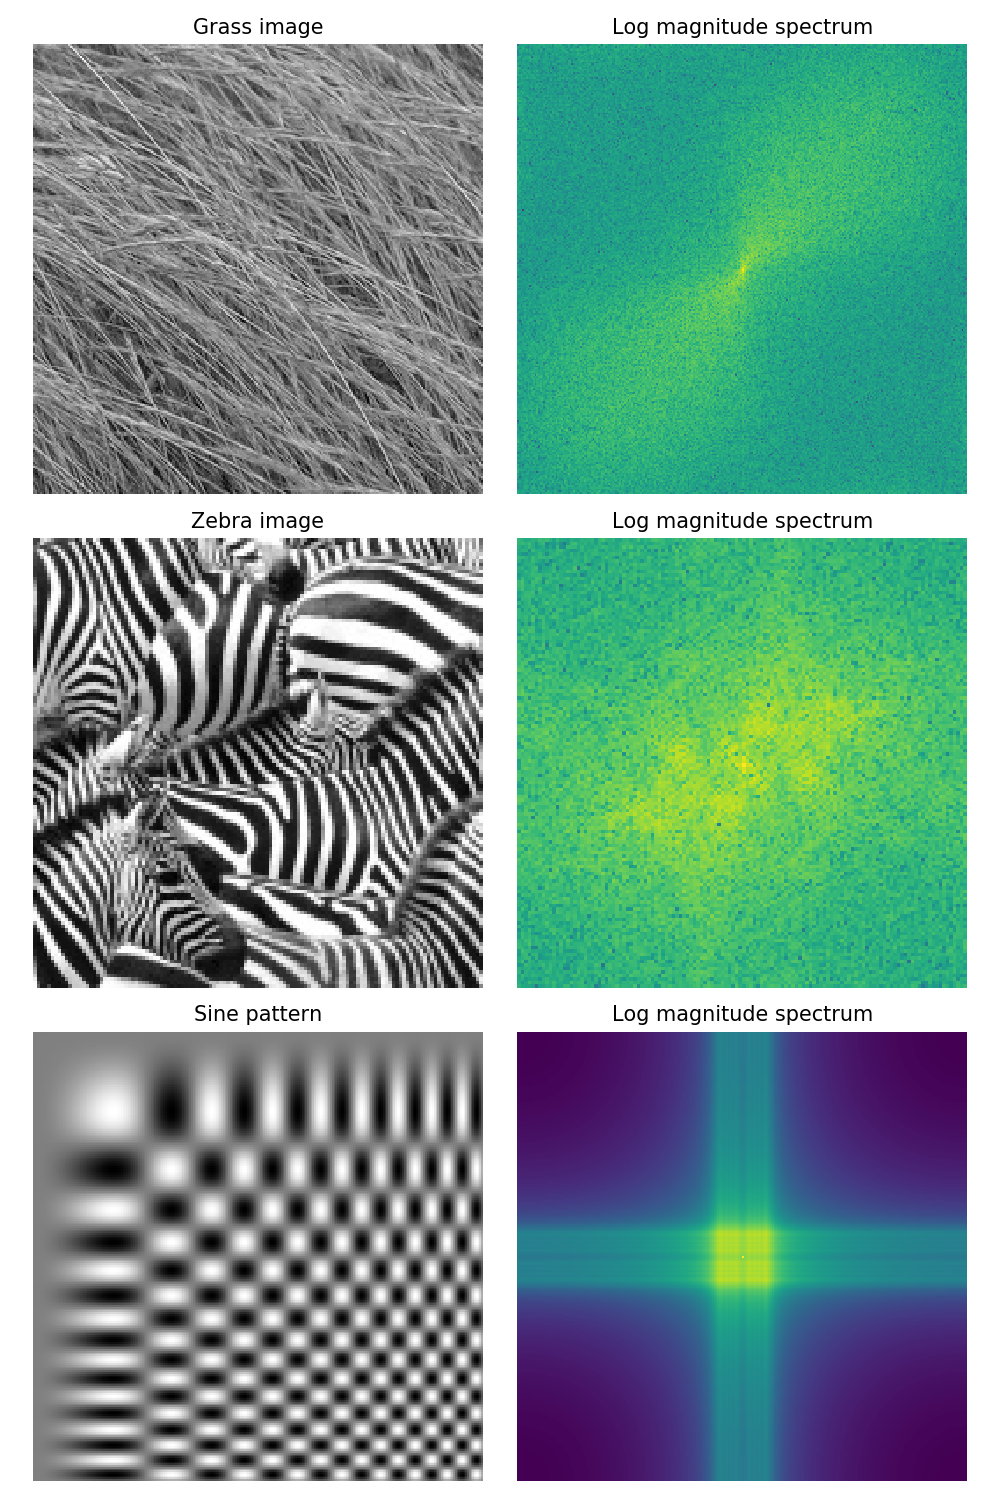

In [3]:
plot_with_spectra([im_grass, im_zebras, im_pattern],
                  ['Grass image', 'Zebra image', 'Sine pattern'])

## (a) Blurring

Consider one of the images (`im_grass` is a good choice).

### i)
Implement `filter_box(image, size)` that outputs the box-filtered version of `image`, using `convolve_with_two` (since the box filter is separable). The parameter `size` refers to the side length of the box filter.

### ii) 
Implement `filter_gauss(image, kernel_factor, sigma)` using `convolve_with_two`. The parameter `kernel_factor` defines the half size of the kernel relative to sigma (our rule of thumb from the lecture was to set this as 3).

Plot the image and its blurred versions (with the box and the Gauss filter) along with their spectra using `plot_with_spectra()`.

Vary the size of the box filter. What do you observe? For the Gaussian, change sigma.  What happens if you increase or decrease the `kernel_factor` compared to our rule-of-thumb value 3?

10


<IPython.core.display.Javascript object>


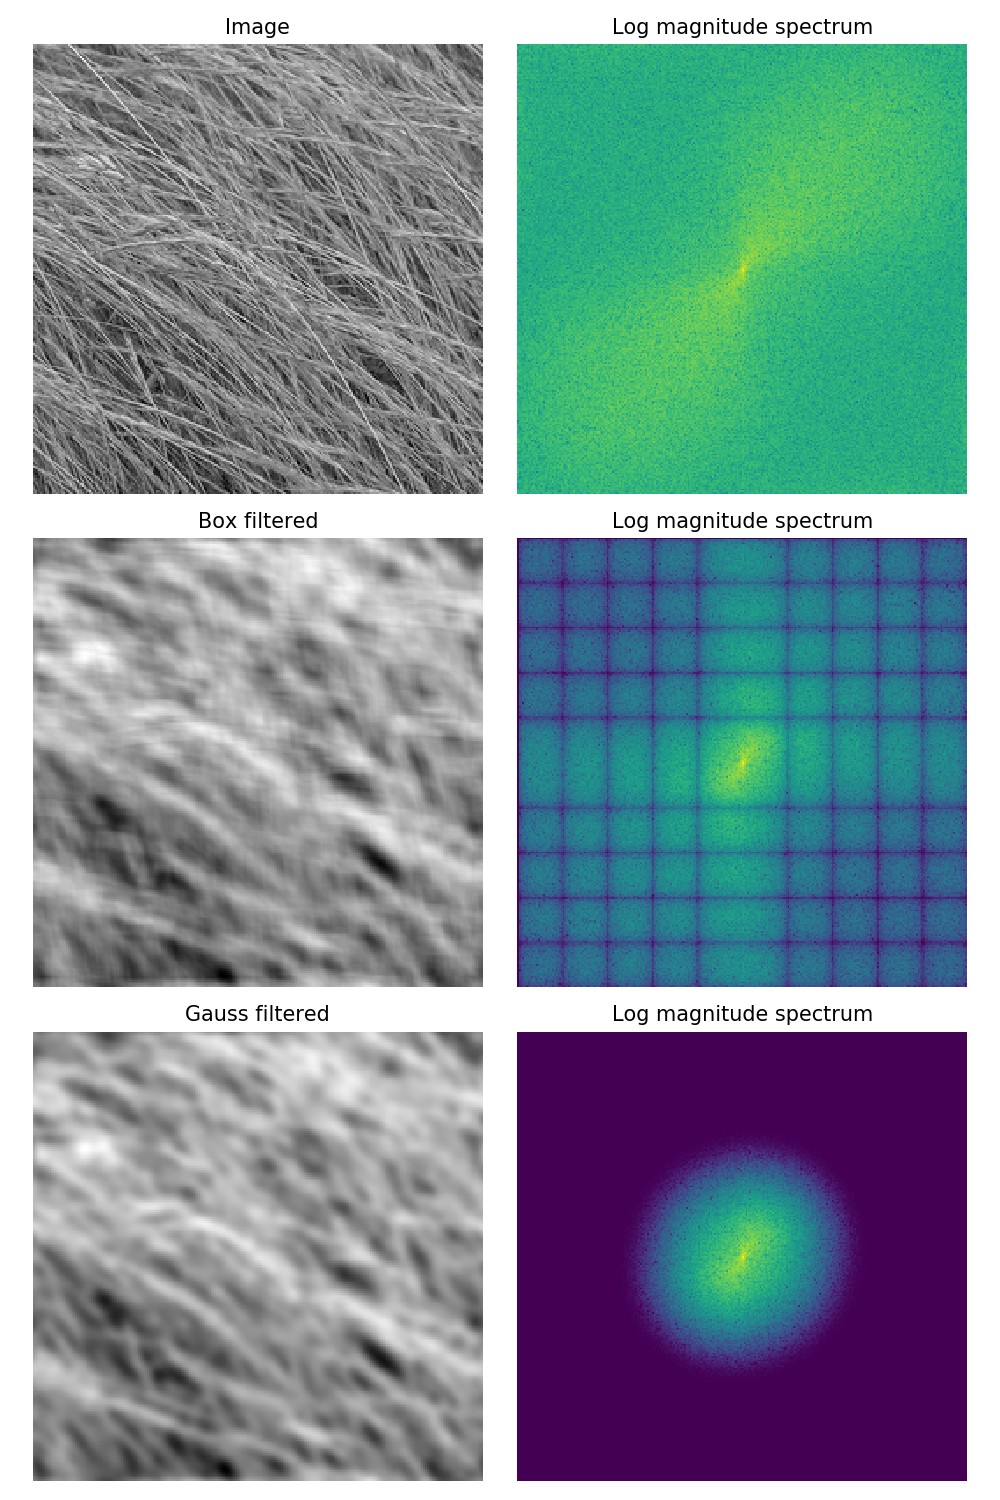

In [4]:
def gauss(x, sigma):
    x = np.exp(-x**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
    return x

def filter_gauss(image, kernel_factor, sigma):
    # size of the kernel : kernel_size
    # the interval of kernel is in the range of [-kernel_range,kernel_range]
    kernel_range = int(np.round(kernel_factor*sigma))
    kernel_size = 2*kernel_range + 1
    
    # x : the input for computing Gaussian kernel
    x = np.linspace(-kernel_range, kernel_range, kernel_size, dtype=float)
    # function gauss() generate Gaussian distribution
    kernel = gauss(x , sigma)
    # normalize kernel
    kernel = kernel / np.sum(kernel)
    
    # add another dimension to kernel
    #  if kernel.shape = (13,)
    #  then : with np.expand_dims(kernel, axis=-1) ---> kernel.shape = (13,1)
    kernel = np.expand_dims(kernel, axis=-1)

    return convolve_with_two(image, np.transpose(kernel),kernel)


def filter_box(image, size):
    size = size * 3 + 1 
    box_filter = np.ones(size)/(size)
    box_filter = np.expand_dims(box_filter, axis=-1)
    print(len(box_filter))
    return convolve_with_two(image, np.transpose(box_filter), box_filter)

size = 3
sigma = size
kernel_factor = 2*sigma

im = im_grass
box_filtered = filter_box(im, size)
gauss_filtered = filter_gauss(im, kernel_factor, sigma)

plot_with_spectra(
     [im, box_filtered, gauss_filtered], 
     ['Image', 'Box filtered', 'Gauss filtered'])

## (b) Sampling and aliasing

### i)

Implement a function `sample_with_gaps(image, period)`, where `period` is an integer and defines the distance between two sampled points in pixels. The output should have the same size as `image` but have zeros everywhere except at the sampled points, where it should be equal to `image`. For example if `period=2` then every second row and every second column of the image should be zero in the output.

Using `sample_with_gaps`, sample the `im_zebras` image with a period of 2 pixels and plot the original and sampled images along with their spectra.

### ii)
Consider the image `im_pattern` and sample it with a period of 4, 8 and 16 and plot the resulting spectra. What happens as you increase the sampling period?
Now apply **Gaussian blurring** before sampling, with different sigma values. Approximately what sigma do you need for avoiding artifacts when `period=16`?

### iii)
Implement `sample_without_gaps(image, period)`, which is like `sample_with_gaps` but the output does not contain gaps (rows and columns of zeros) and therefore the output size is smaller. What effect do you see in the resulting magnitude spectrum, compared to `sample_with_gaps`?

In [5]:
np.arange(0,10,1)[::2]

array([0, 2, 4, 6, 8])

In [6]:
def sample_with_gaps(image, period):
    im = np.zeros_like(image)
    im[::period,::period] = image[::period,::period]
    return im

def sample_without_gaps(image, period):
    return image[::period,::period]

<IPython.core.display.Javascript object>


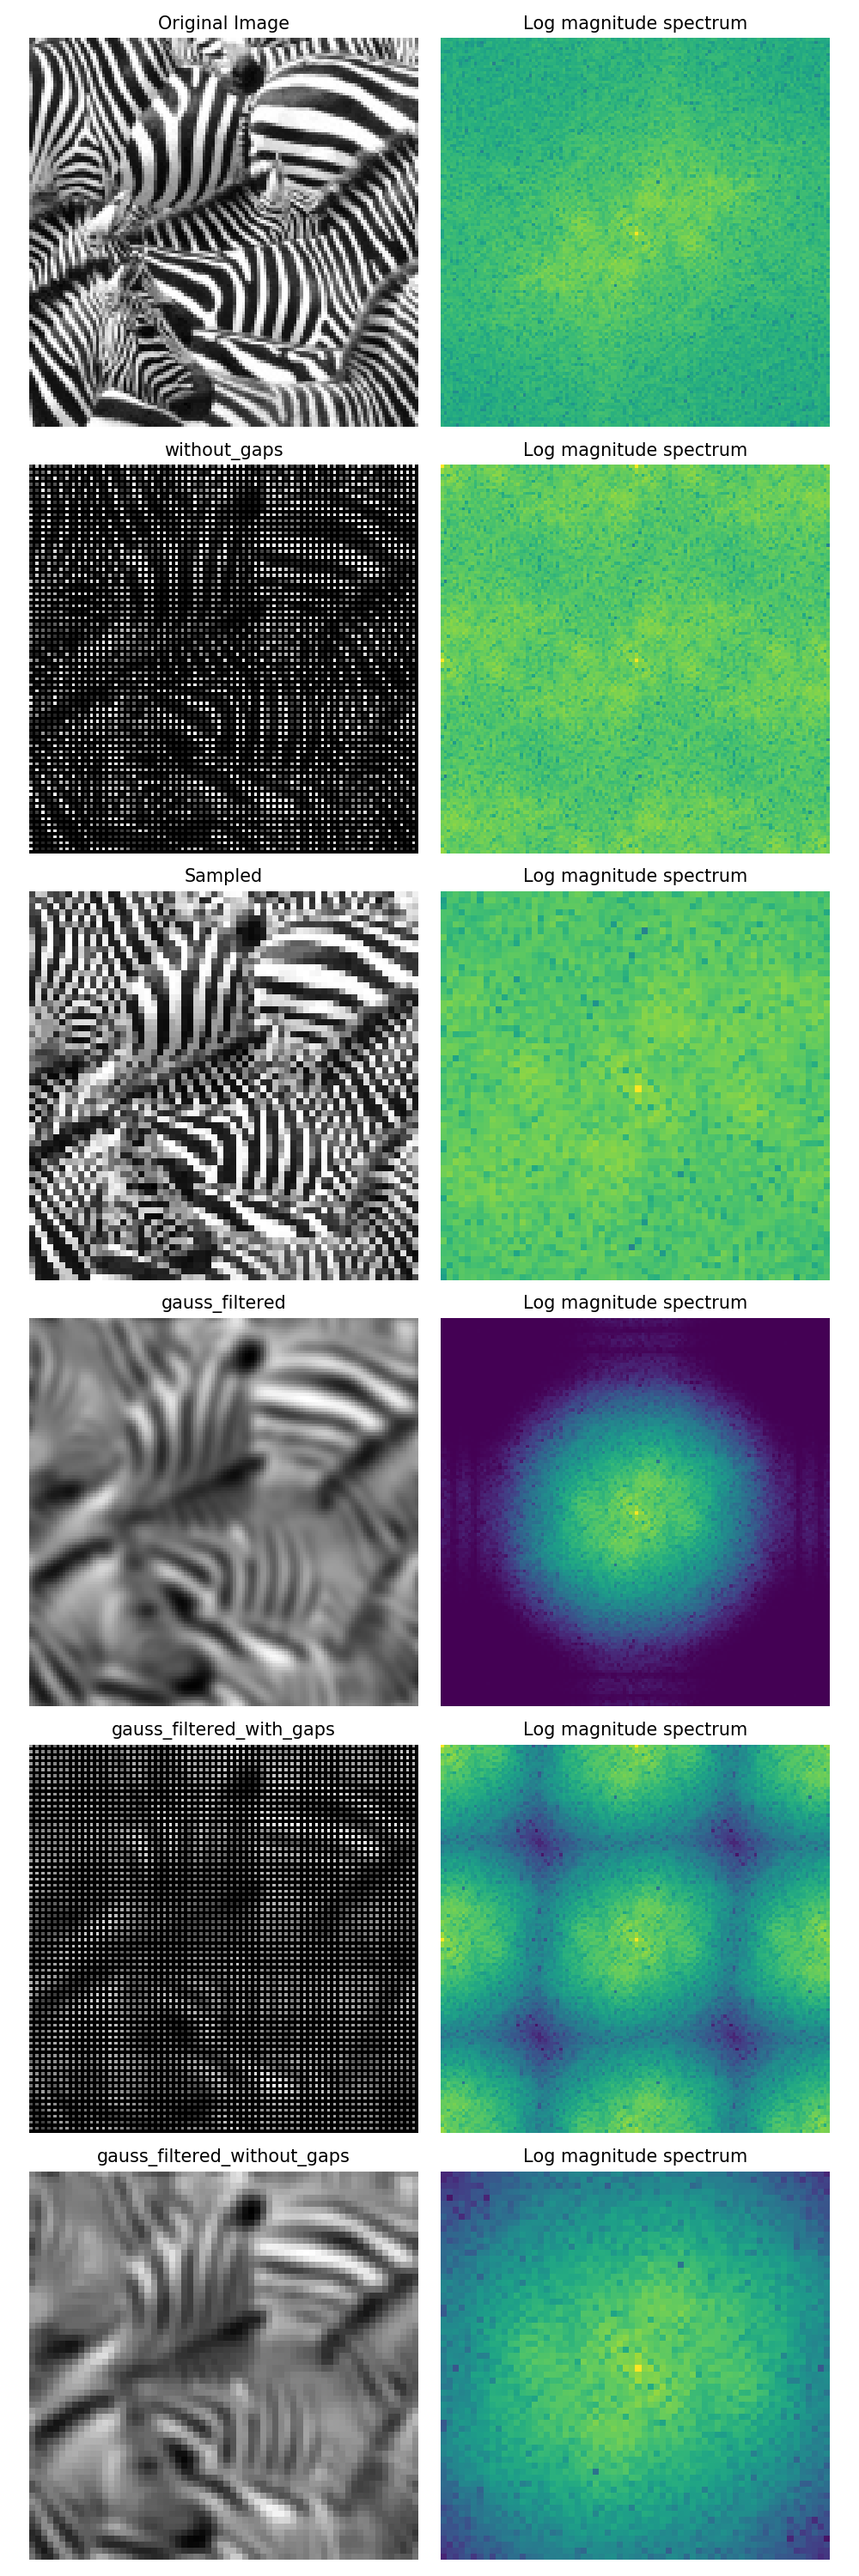

In [7]:
period = 2
im = im_zebras
with_gaps = sample_with_gaps(im, period)
#just sampled
without_gaps = sample_without_gaps(im, period)

#Gaussian blurring before sampling
size = 2
sigma = size
kernel_factor = 2*sigma
gauss_filtered = filter_gauss(im, kernel_factor, sigma)
gauss_filtered_with_gaps = sample_with_gaps(gauss_filtered, period)
gauss_filtered_without_gaps = sample_without_gaps(gauss_filtered, period)


plot_with_spectra(
    [im, with_gaps, without_gaps, gauss_filtered, gauss_filtered_with_gaps, gauss_filtered_without_gaps], 
    ['Original Image', 'without_gaps', 'Sampled', 'gauss_filtered', 'gauss_filtered_with_gaps', 'gauss_filtered_without_gaps'])

<IPython.core.display.Javascript object>


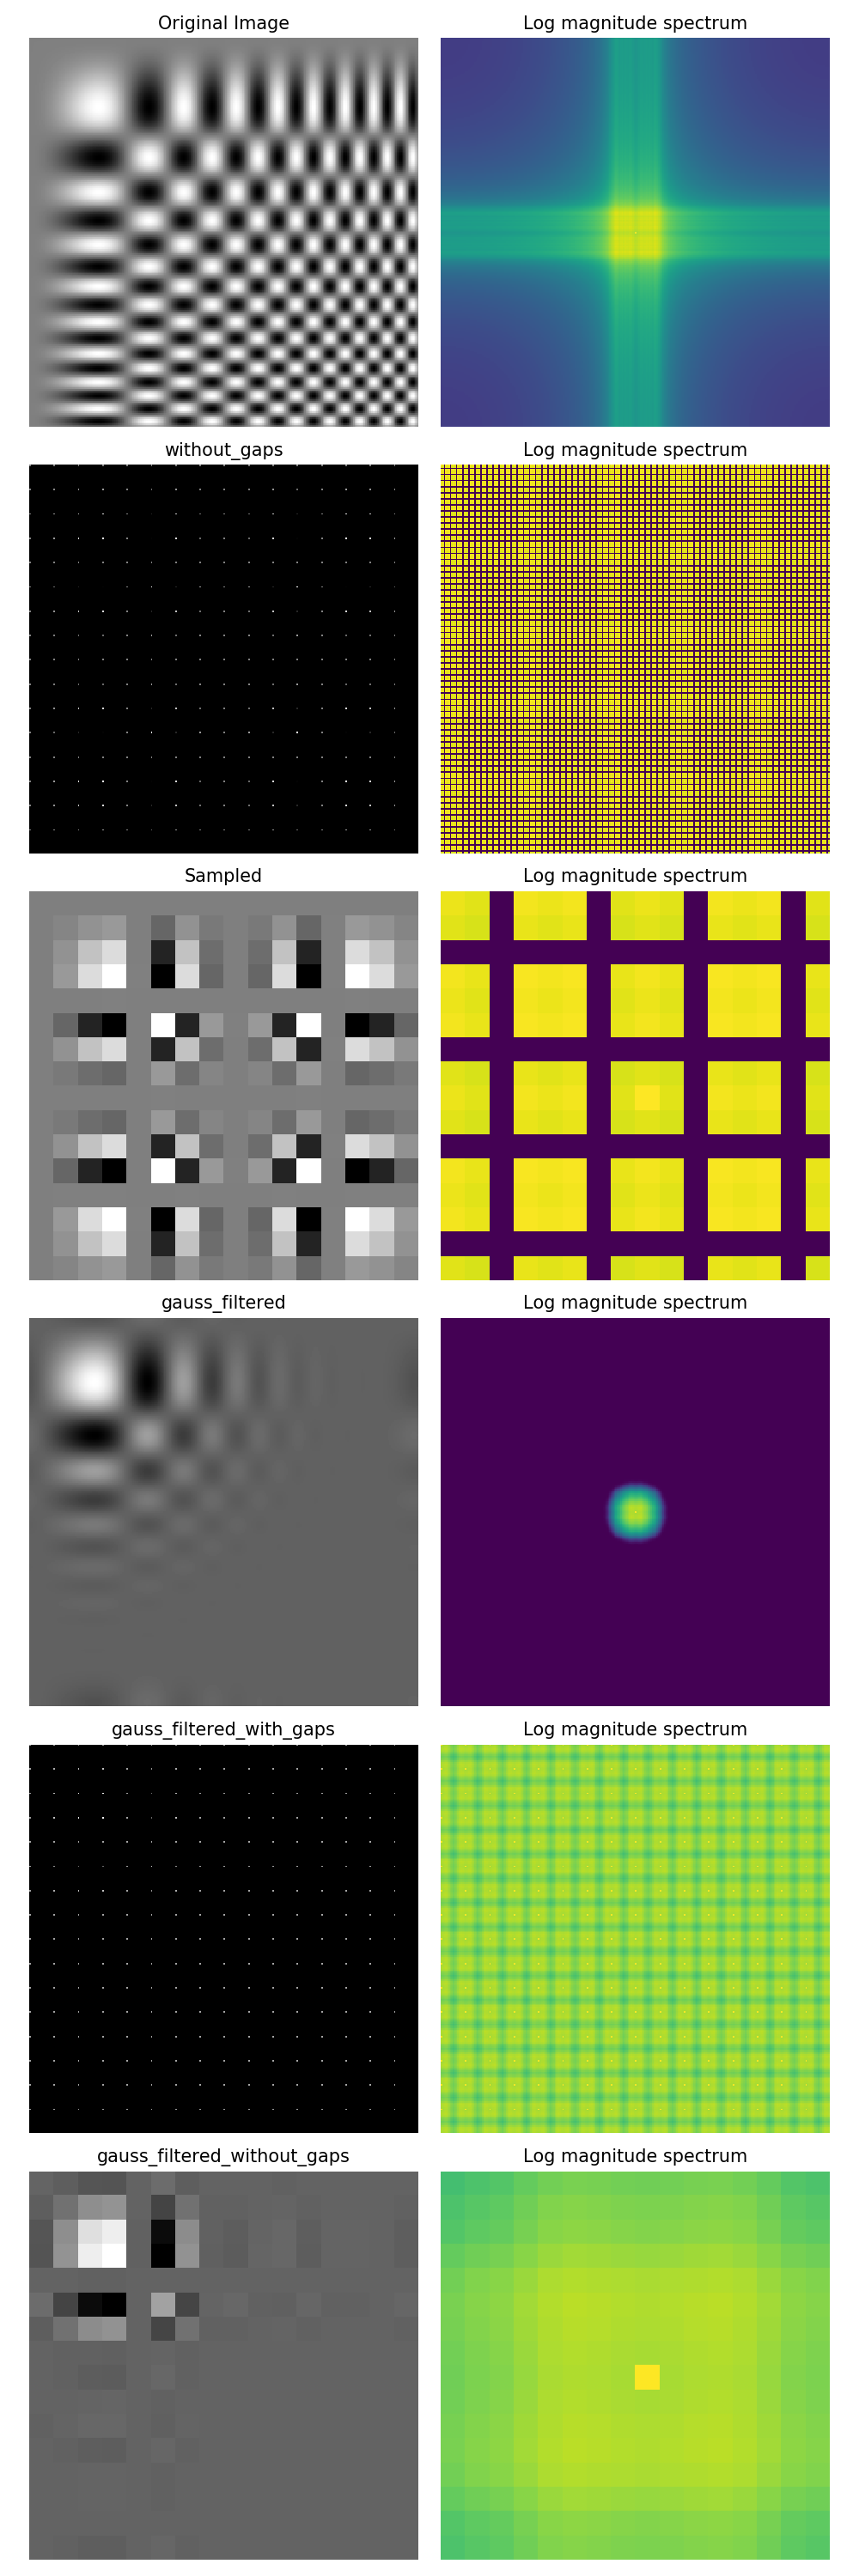

In [8]:
period = 16
im = im_pattern
with_gaps = sample_with_gaps(im, period)
#just sampled
without_gaps = sample_without_gaps(im, period)

#Gaussian blurring before sampling
size = 10
sigma = size
kernel_factor = 2*sigma
gauss_filtered = filter_gauss(im, kernel_factor, sigma)
gauss_filtered_with_gaps = sample_with_gaps(gauss_filtered, period)
gauss_filtered_without_gaps = sample_without_gaps(gauss_filtered, period)


plot_with_spectra(
    [im, with_gaps, without_gaps, gauss_filtered, gauss_filtered_with_gaps, gauss_filtered_without_gaps], 
    ['Original Image', 'without_gaps', 'Sampled', 'gauss_filtered', 'gauss_filtered_with_gaps', 'gauss_filtered_without_gaps'])